In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)
import seaborn as sns
from sklearn import preprocessing
from sklearn import model_selection
import sklearn
import xgboost

In [2]:
home = pd.read_csv("Bengaluru_House_Data.csv")
home.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
home.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


## Data Preprocessing!

In [4]:
## finding null values in %form

round(100*(home.isnull().sum()/len(home.index)),2)

area_type        0.00
availability     0.00
location         0.01
size             0.12
society         41.31
total_sqft       0.00
bath             0.55
balcony          4.57
price            0.00
dtype: float64

In [5]:
#removing NaN values from the dataset
home.dropna(inplace =True)

In [6]:
home = home.drop(columns='society')

In [7]:
home.reset_index(drop= True, inplace =True)

In [8]:
home['bhk'] = home['size'].str.split().str[0]
home['bhk'].dropna(inplace = True)
home['bhk'] = home['bhk'].astype('int')

In [9]:
print(home['total_sqft'].iloc[[17]])

## fucntion to remove 2100 - 2850 by taking there average
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

17    2100 - 2850
Name: total_sqft, dtype: object


In [10]:
## applying the fucntion to the column: - 'total_sqft'
home.total_sqft = home.total_sqft.apply(convert_sqft_to_num)
# Taking only the Numeric values from the data and storing it in 'home'
home = home[home.total_sqft.notnull()]
# display the first 2 columns from the dataset
home.head(2)

,area_type,availability,location,size,total_sqft,bath,balcony,price,bhk
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,2
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00,4


In [11]:
##removing invalid data entry
## Example: The total sqft divided by the number of bhk should always be more than 300

home = home[~(home.total_sqft/home.bhk<200)]
home.shape

(7478, 9)

In [12]:
## dividing the dataset into Continous and Categorical variables:
cont_ = home.select_dtypes(exclude = 'object')
cat_ = home.select_dtypes(include  = 'object')

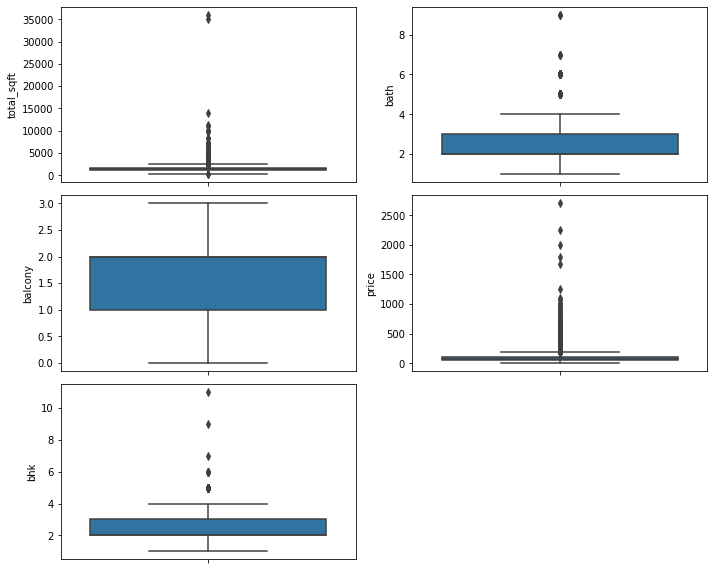

In [13]:
## displaying only the continous variables from the dataset
## to determine the variables which have outliers and those which needs to be removed
fig = plt.figure(figsize = (10,8))
for index,col in enumerate(cont_):
    plt.subplot(3,2,index+1)
    sns.boxplot(y = cont_.loc[:,col])
fig.tight_layout(pad = 1.0)

In [14]:
home = home.drop(home[home['bath']>6].index)
home = home.drop(home[home['bhk']>7.0].index)

In [15]:
## Feature Engineering step
home['price_per_sqft'] = home['price']*100000/home['total_sqft']
home.head()

,area_type,availability,location,size,total_sqft,bath,balcony,price,bhk,price_per_sqft
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,2,3699.810606
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00,4,4615.384615
2,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,1521.0,3.0,1.0,95.00,3,6245.890861
3,Super built-up Area,Ready To Move,Whitefield,2 BHK,1170.0,2.0,1.0,38.00,2,3247.863248
4,Plot Area,Ready To Move,Whitefield,4 Bedroom,2785.0,5.0,3.0,295.00,4,10592.459605


In [16]:
home['price_per_sqft'].describe()

count     7471.000000
mean      5853.051952
std       2720.468727
min        371.428571
25%       4277.681409
50%       5315.315315
75%       6693.387739
max      76530.612245
Name: price_per_sqft, dtype: float64

In [17]:
## taking only the values with 1st Standard devaition values.
## as per Normal Distribution, 95% of our data lies within 1st Standard Deviation as per the location

def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
home = remove_pps_outliers(home)
home.shape

(5389, 10)

<AxesSubplot:>

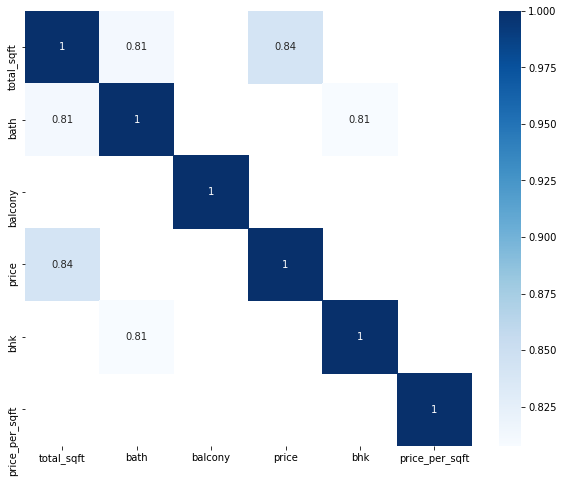

In [18]:
## finding correlation values within the dataset
## we remove features which are highly related to each other as they do not provide
## any significance value to our Model

corr = home.corr()
plt.figure(figsize = (10,8))
sns.heatmap(corr,mask = corr<0.8 ,annot= True,cmap = 'Blues')

In [19]:
home.drop(columns=['availability','size','area_type'],inplace = True)

In [20]:
## checking the dataset with highest location data provided
## because havind values for a location less than 10 wont give us good information on the dataset

home.location = home.location.str.strip()
location_stats = home['location'].value_counts(ascending=False)
location_stats

Whitefield              357
Sarjapur  Road          240
Electronic City         225
Kanakpura Road          157
Thanisandra             141
                       ... 
Green Garden Layout       1
Poorna Pragna Layout      1
Mahalakshmi Layout        1
Doddanekundi              1
Hiremath Layout           1
Name: location, Length: 430, dtype: int64

In [21]:
## cretaing a Series of all the location having less than 10 entries against its  
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

Gubbalala               10
Neeladri Nagar          10
Seegehalli              10
Munnekollal             10
Anandapura              10
                        ..
Green Garden Layout      1
Poorna Pragna Layout     1
Mahalakshmi Layout       1
Doddanekundi             1
Hiremath Layout          1
Name: location, Length: 319, dtype: int64

In [22]:
## using lambda function to naming 'location_stats_less_than_10' as 'other' and then removing it

home.location = home.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)

home = home[home.location != 'other']

In [23]:
## Keeping in mind that the number of Bathroom shouldn't be more than BHK+2
## Example for a 3 bhk, the number of bathrooms shouldn't be more than 5

home = home[home.bath<home.bhk+2]

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


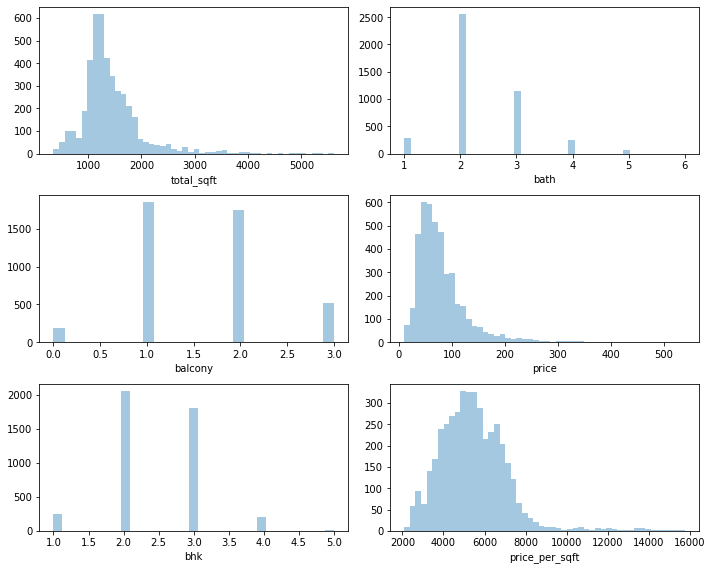

In [24]:
## representing Numerical Data and Visualizing the same usin Distplot to gain further info

num_ = home.select_dtypes(exclude = 'object')
fig = plt.figure(figsize =(10,8))
for index, col in enumerate(num_):
    plt.subplot(3,2,index+1)
    sns.distplot(num_.loc[:,col],kde = False)
fig.tight_layout(pad = 1.0)

In [25]:
## performing One hot encoding on the Categorical values
## 1st step. create dummies
dummies = pd.get_dummies(home.location)
dummies.head(3)

,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,Abbigere,Akshaya Nagar,Ambalipura,Ambedkar Nagar,Ardendale,Attibele,BTM 2nd Stage,...,Thubarahalli,Tumkur Road,Uttarahalli,Varthur,Vijayanagar,Vittasandra,Whitefield,Yelahanka,Yelahanka New Town,Yeshwanthpur
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
## adding the dummies dataframe to our main DataFrame

home = pd.concat([home,dummies],axis='columns')

## removing 'location' as we have already created the dummies
home1 = home.drop('location',axis = 1)

## removing columns which will not be required by our model
home1 = home1.drop(columns=['balcony','price_per_sqft'])
home1

,total_sqft,bath,price,bhk,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,Abbigere,Akshaya Nagar,Ambalipura,...,Thubarahalli,Tumkur Road,Uttarahalli,Varthur,Vijayanagar,Vittasandra,Whitefield,Yelahanka,Yelahanka New Town,Yeshwanthpur
8,550.0,1.0,27.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,440.0,1.0,28.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,510.0,1.0,25.25,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,510.0,1.0,25.25,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44,1080.0,2.0,72.00,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5384,1169.0,2.0,64.08,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5385,2500.0,3.0,138.00,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5386,1160.0,2.0,64.08,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5387,2503.0,3.0,138.00,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [27]:
home1.reset_index(drop = True)

,total_sqft,bath,price,bhk,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,Abbigere,Akshaya Nagar,Ambalipura,...,Thubarahalli,Tumkur Road,Uttarahalli,Varthur,Vijayanagar,Vittasandra,Whitefield,Yelahanka,Yelahanka New Town,Yeshwanthpur
0,550.0,1.0,27.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,440.0,1.0,28.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,510.0,1.0,25.25,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,510.0,1.0,25.25,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1080.0,2.0,72.00,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4298,1169.0,2.0,64.08,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4299,2500.0,3.0,138.00,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4300,1160.0,2.0,64.08,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4301,2503.0,3.0,138.00,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [28]:
## Dividing our dataset to Independent and Dependent Variables

X = home1.drop('price',axis = 1).values ## Independent Variables
y = home1.price.values ## Dependent Variables

In [29]:
## adding a new axis
y = y[:,np.newaxis]

### Standardize features by removing the mean and scaling to unit variance

#### The standard score of a sample x is calculated as:

**z = (x - u) / s**

- where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False.



In [30]:
## preprocessing the data values to StandardScaler
sc = preprocessing.StandardScaler()
X1 = sc.fit_transform(X)


In [31]:
## Standardize a dataset along any axis

## Center to the mean and component wise scale to unit variance.

Std_x1 = preprocessing.scale(X)

## Machine Learning Part

In [32]:
# from the model selection module import train_test_split for the ML training and testing.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1,y,test_size=0.3,random_state=10)

In [33]:
## importing the required libraries for Machine Learning

from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
acc = mean_squared_error(y_pred,y_test)
rscore = r2_score(y_pred,y_test)
print(f'Accuracy with Linear regression : {rscore}')

Accuracy with Linear regression : 0.8995320160983539


In [35]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso()
lasso_reg.fit(X_train,y_train)
y_pred = lasso_reg.predict(X_test)
acc = mean_squared_error(y_pred,y_test)
rscore = r2_score(y_pred,y_test)
print(f'Accuracy with Lasso regression : {rscore}')

Accuracy with Lasso regression : 0.8608167697809426


In [36]:
from sklearn.linear_model import Ridge
Ridge_reg = Ridge()
Ridge_reg.fit(X_train,y_train)
y_pred = Ridge_reg.predict(X_test)
acc = mean_squared_error(y_pred,y_test)
rscore = r2_score(y_pred,y_test)
print(f'Accuracy with Ridge regression : {rscore}')

Accuracy with Ridge regression : 0.8994713868000848


In [37]:
from xgboost import XGBRegressor
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train,y_train)
y_pred = xgb_reg.predict(X_test)
acc = mean_squared_error(y_pred,y_test)
rscore = r2_score(y_pred,y_test)
print(f'Accuracy with Extreme Gradient Boosting regression : {rscore}')

Accuracy with Extreme Gradient Boosting regression : 0.9070356585958991


In [40]:
from sklearn.ensemble import RandomForestRegressor
RF_reg = RandomForestRegressor()
RF_reg.fit(X_train,y_train)
y_pred = RF_reg.predict(X_test)
acc = mean_squared_error(y_pred,y_test)
rscore = r2_score(y_pred,y_test)
print(f'Accuracy with Random Forest Regressor regression : {rscore}')

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Accuracy with Random Forest Regressor regression : 0.8967576899712868
